**Project Title: Gold Price Prediction**

**Objective:** To build a machine learning model that accurately predicts gold prices (GLD) using key financial indicators like stock indices, oil prices, and currency exchange rates.

In [2]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/My Drive/Kaggle projects/Gold Price Prediction')

**Data Loading**

In [5]:
gold_data=pd.read_csv('gld_price_data.csv')
gold_data.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


**Data Exploration**

In [5]:
gold_data.shape

(2290, 6)

In [39]:
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB


In [7]:
gold_data.isnull().sum() #checking missing values

,0
Date,0
SPX,0
GLD,0
USO,0
SLV,0
EUR/USD,0


In [8]:
gold_data.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1654.315776,122.732875,31.842221,20.084997,1.283653
std,519.111540,23.283346,19.523517,7.092566,0.131547
min,676.530029,70.000000,7.960000,8.850000,1.039047
25%,1239.874969,109.725000,14.380000,15.570000,1.171313
50%,1551.434998,120.580002,33.869999,17.268500,1.303297
75%,2073.010070,132.840004,37.827501,22.882500,1.369971
max,2872.870117,184.589996,117.480003,47.259998,1.598798


In [61]:
#checking duplicate dates
gold_data[gold_data.duplicated(['Date'])]

,Date,SPX,GLD,USO,SLV,EUR/USD


**Data Preprocessing**

In [6]:
#Converting to Date format
gold_data['Date'] = pd.to_datetime(gold_data['Date'])

In [7]:
gold_data.set_index('Date', inplace=True) #set index as Date
gold_data.head()

,SPX,GLD,USO,SLV,EUR/USD
Date,,,,,
2008-01-02,1447.160034,84.860001,78.470001,15.180,1.471692
2008-01-03,1447.160034,85.570000,78.370003,15.285,1.474491
2008-01-04,1411.630005,85.129997,77.309998,15.167,1.475492
2008-01-07,1416.180054,84.769997,75.500000,15.053,1.468299
2008-01-08,1390.189941,86.779999,76.059998,15.590,1.557099


**Exploratory Data Analysis**

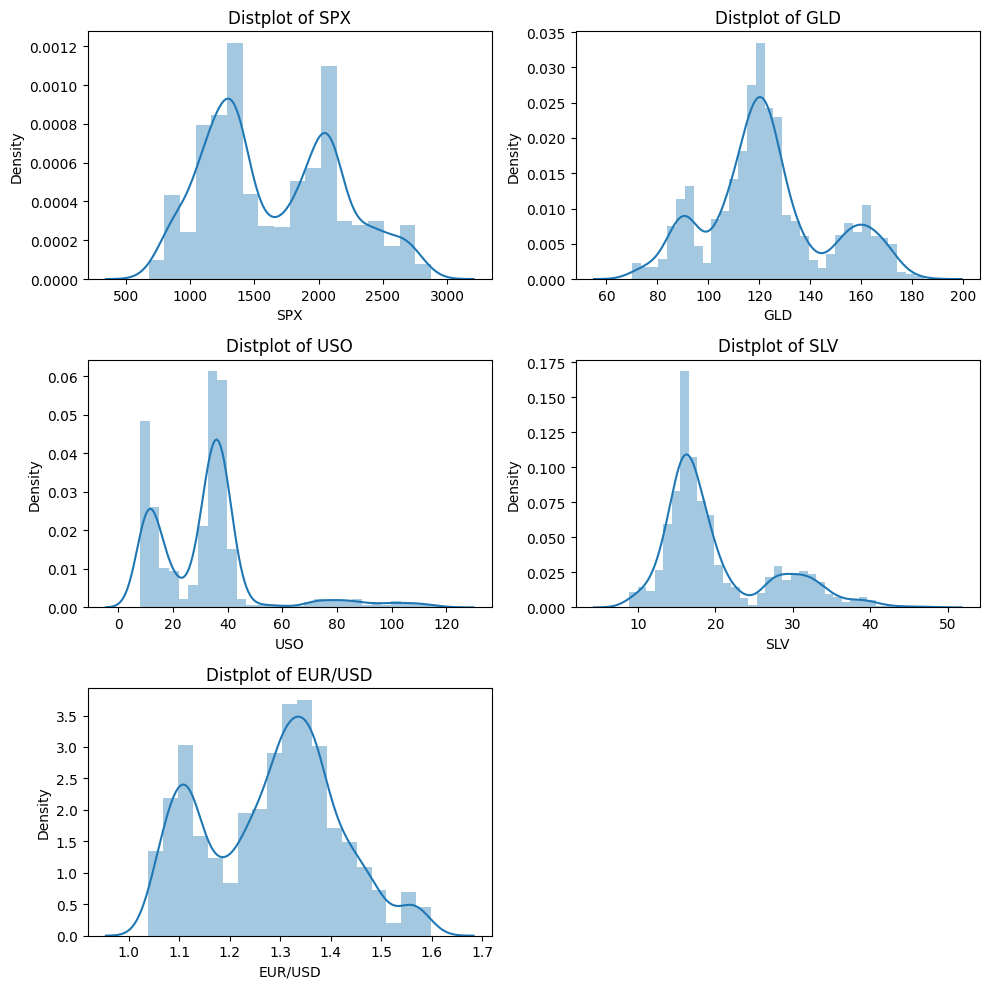

In [23]:
#Univariant Analysis
df_gold=gold_data.copy()
df_gold.head()

df_numerical=df_gold.drop(['Date'],axis=1)

# Distributions of numerical features
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
axes = axes.flatten()
for i, col in enumerate(df_numerical.columns):
    sns.distplot(df_numerical[col], ax=axes[i])
    axes[i].set_title(f'Distplot of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Observations:** The distribution plots show a variety of shapes across the different financial indicators. SPX (S&P 500) appears right-skewed with multiple peaks, suggesting different market cycles over time. GLD (Gold prices) is fairly normally distributed but with a slight skew, indicating a consistent trading range. USO (oil prices) and SLV (silver prices) both show noticeable right-skewness and bimodal patterns, hinting at historical shocks or volatility in the commodities market. EUR/USD shows a clear bimodal distribution, which could reflect changing monetary policies or economic conditions across time.

<Axes: >

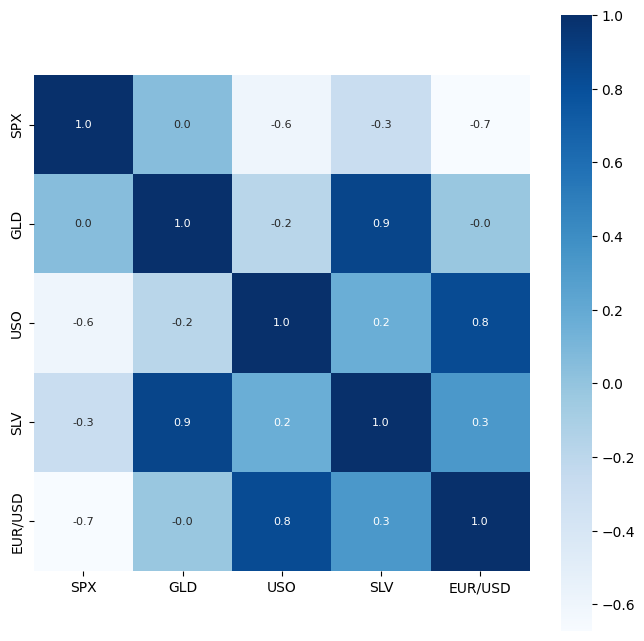

In [25]:
# correlation
plt.figure(figsize = (8,8))
sns.heatmap(df_numerical.corr(), cbar=True, square=True, fmt='.1f',annot=True, annot_kws={'size':8}, cmap='Blues')

**Observations:** In the correlation matrix, GLD and SLV are strongly linked, moving together. SPX has little correlation with gold but is negatively related to oil and the EUR/USD rate. USO and EUR/USD are positively correlated, likely due to global economic factors.

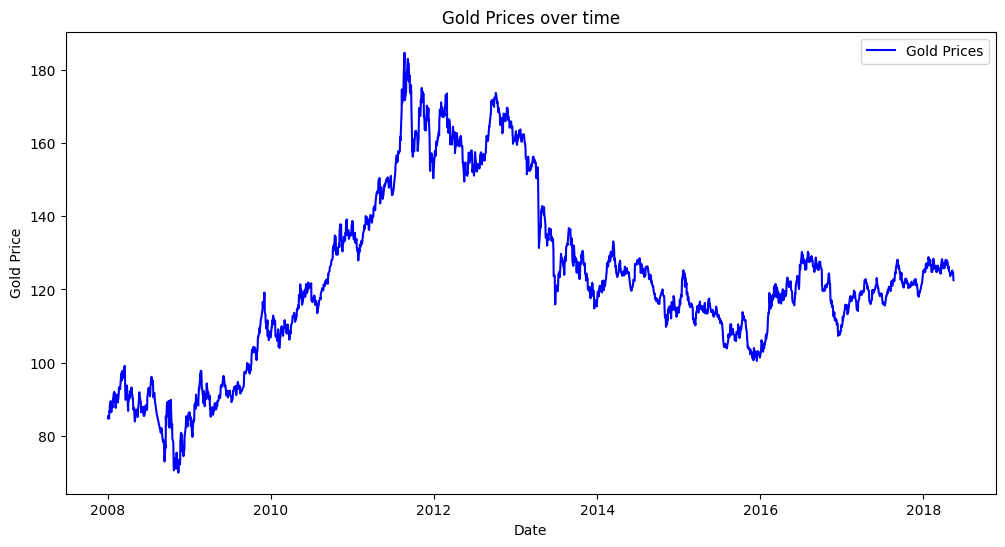

In [8]:
# Gold prices over time
plt.figure(figsize=(12, 6))
plt.plot(gold_data.index, gold_data['GLD'], label="Gold Prices", color="blue")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.title("Gold Prices over time")
plt.legend()
plt.show()

**Observations:** Gold prices show a general upward trend over time, but with clear fluctuations. There may be some seasonality to these price swings. A sharper price increase is apparent in the more recent data.


**Time Series Decomposition**

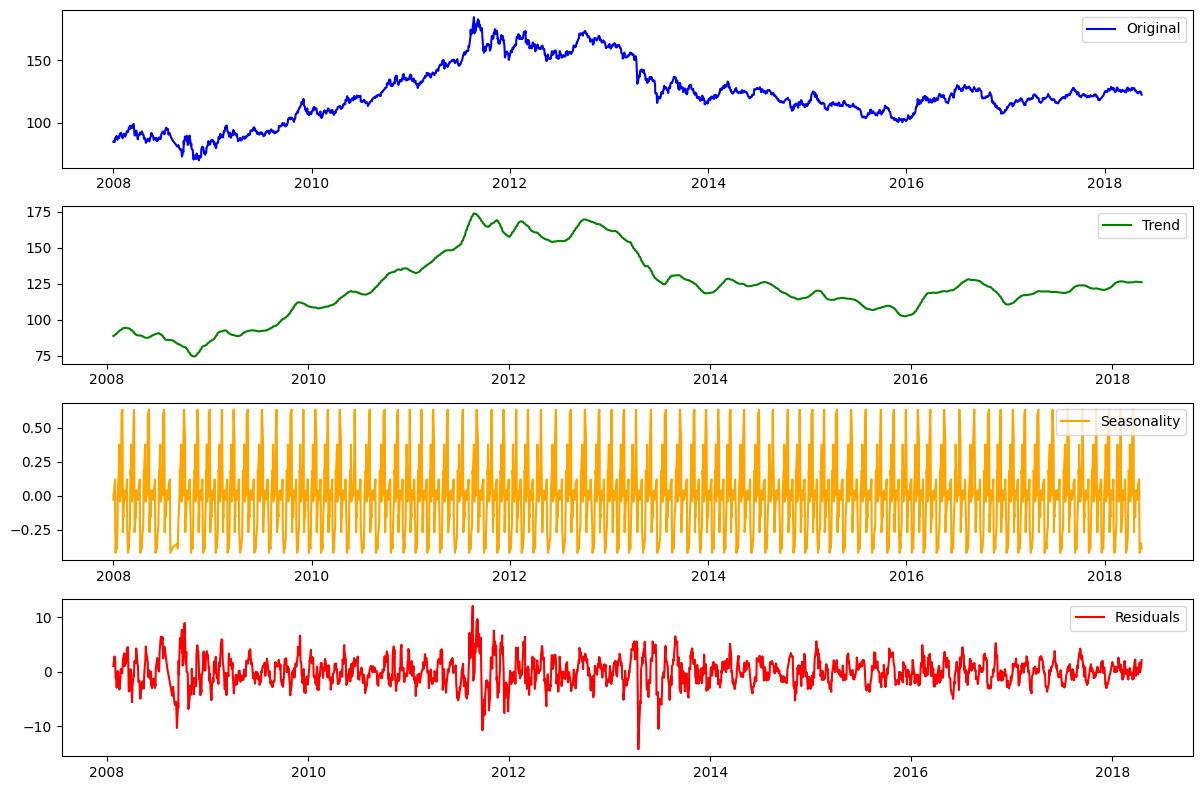

In [9]:
#Decomposing time series into Trend, Seasonality, and Residuals
decomposition = seasonal_decompose(gold_data['GLD'], model='additive', period=30)  # Using 'gold_data' and 'GLD' column

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(gold_data['GLD'], label='Original', color='blue')  # Using 'gold_data' and 'GLD' column
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='orange')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**Observations:** This time series decomposition shows clear and regular patterns. The **original series** has a repeating upward pattern, indicating strong cyclic behavior over the years. The **trend** component steadily increases in steps, suggesting periodic resets or cycles in the overall level. The **seasonality** is consistent throughout the time span, showing a repeating short-term pattern, likely monthly or quarterly. The **residuals** reveal sharp spikes at regular intervals, meaning some events aren't fully explained by trend or seasonality—possibly anomalies or outliers.


In [10]:
#checking data is stationary or not
adf_test = adfuller(gold_data['GLD'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

if adf_test[1] < 0.05:
    print("p-value is lessthan 0.05. Data is stationary (Reject H₀)")
else:
    print("p-value is greaterthan 0.05. Data is NOT stationary (Fail to reject H₀)")

ADF Statistic: -1.6188844282199566
p-value: 0.4733141978661517
p-value is greaterthan 0.05. Data is NOT stationary (Fail to reject H₀)


In [8]:
#Data is non-stationary so performing differencing method to make stationary
gold_data['GLD_diff'] = gold_data['GLD'].diff().dropna()

**Modelling & Evaluation**

In [11]:
X = gold_data.drop(['Date','GLD'],axis=1)
Y = gold_data['GLD']

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

In [19]:
#Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train,Y_train)
Lr_prediction = linear_model.predict(X_test)
Lr_error_score = r2_score(Y_test, Lr_prediction)
print("R squared error : ", Lr_error_score)
Lr_MSE = mean_squared_error(Y_test, Lr_prediction)
print("mean squared error : ", Lr_MSE)

R squared error :  0.8657886565869237
mean squared error :  70.7889007972153


In [16]:
#Random Forest
RF = RandomForestRegressor(n_estimators=100)
# training the model
RF.fit(X_train,Y_train)
# prediction on Test Data
RF_prediction = RF.predict(X_test)
RF_error_score = r2_score(Y_test, RF_prediction)
print("R squared error : ", RF_error_score)

R squared error :  0.9892158179493291


In [18]:
RF_MSE = mean_squared_error(Y_test, RF_prediction)
print("mean squared error : ", RF_MSE)

mean squared error :  5.68804673249156


                               SARIMAX Results                                
Dep. Variable:                    GLD   No. Observations:                 2290
Model:                 ARIMA(5, 2, 1)   Log Likelihood               -4231.976
Date:                Thu, 08 May 2025   AIC                           8477.952
Time:                        11:00:31   BIC                           8518.100
Sample:                             0   HQIC                          8492.593
                               - 2290                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0367      0.016     -2.262      0.024      -0.068      -0.005
ar.L2          0.0253      0.015      1.634      0.102      -0.005       0.056
ar.L3         -0.0435      0.017     -2.500      0.0

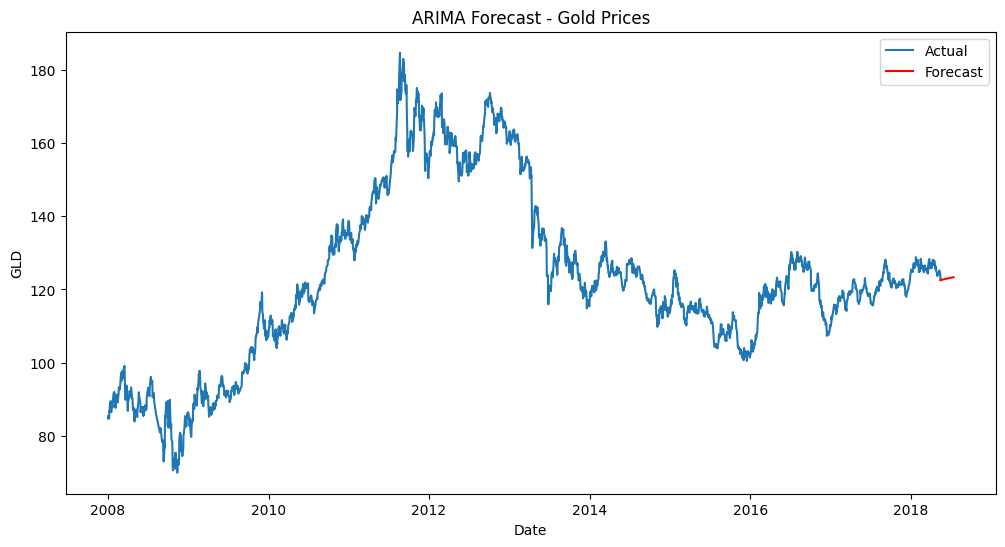

In [20]:
model = ARIMA(gold_data['GLD'], order=(5,2,1))
model_fit = model.fit()
print(model_fit.summary())

forecast = model_fit.forecast(steps=60) # forecast for 60days

plt.figure(figsize=(12, 6))
plt.plot(gold_data.index, gold_data['GLD'], label="Actual")
plt.plot(pd.date_range(start=gold_data.index[-1], periods=60, freq='D'), forecast, label="Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("GLD")
plt.title("ARIMA Forecast - Gold Prices")
plt.legend()
plt.show()

In [10]:
# SARIMA(p,d,q)(P,D,Q,s)
model = SARIMAX(gold_data['GLD'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                GLD   No. Observations:                 2290
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4236.021
Date:                            Thu, 08 May 2025   AIC                           8482.041
Time:                                    10:57:15   BIC                           8510.694
Sample:                                         0   HQIC                          8492.493
                                           - 2290                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9863      0.011    -90.358      0.000      -1.008      -0.965
ma.L1          0.9736      0.014   

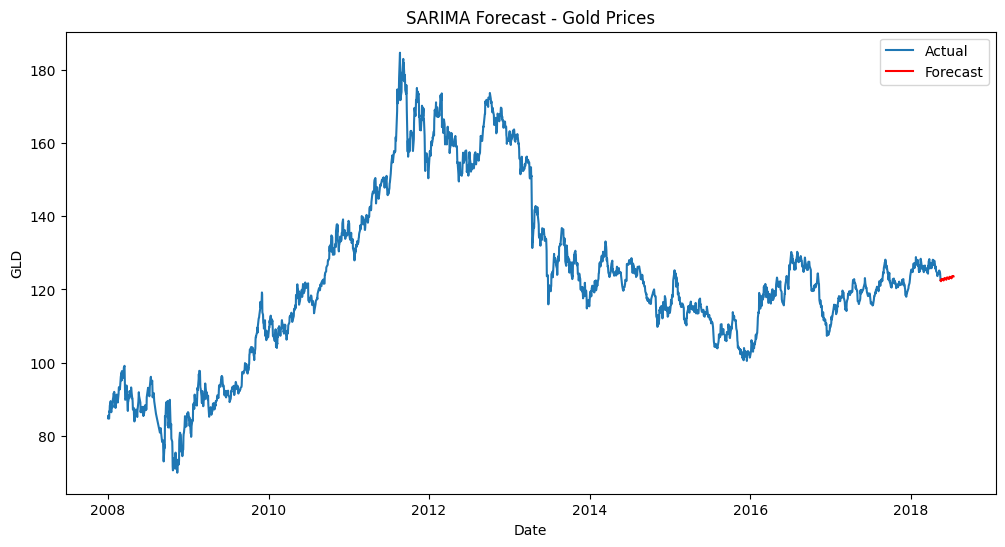

In [12]:
forecast = model_fit.forecast(steps=60)

plt.figure(figsize=(12, 6))
plt.plot(gold_data.index, gold_data['GLD'], label="Actual")
plt.plot(pd.date_range(start=gold_data.index[-1], periods=60, freq='D'), forecast, label="Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("GLD")
plt.title("SARIMA Forecast - Gold Prices")
plt.legend()
plt.show()


**Conclusion:** The model, particularly the Random Forest Regressor, performed well in predicting gold prices, showing a strong correlation between the selected financial features and gold value. This demonstrates the potential of machine learning in financial forecasting and investment decision support.